In [49]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re

# Context

In [2]:
titanic_filepath = "./titanic/train.csv"
titanic_data = pd.read_csv(titanic_filepath, index_col="PassengerId")

titanic_data.head()

Survived  Pclass  \
PassengerId                     
1                   0       3   
2                   1       1   
3                   1       3   
4                   1       1   
5                   0       3   

                                                          Name     Sex   Age  \
PassengerId                                                                    
1                                      Braund, Mr. Owen Harris    male  22.0   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
3                                       Heikkinen, Miss. Laina  female  26.0   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
5                                     Allen, Mr. William Henry    male  35.0   

             SibSp  Parch            Ticket     Fare Cabin Embarked  
PassengerId                                                          
1                1      0         A/5 21171   7.2500   NaN        S  
2                1      0          PC 17599  71.2833   C85        C  
3                0      0  STON/O2. 3101282   7.9250   NaN        S  
4                1      0            113803  53.1000  C123        S  
5                0      0            373450   8.0500   NaN        S

# Data quality assessment

In [3]:
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [4]:
titanic_data.shape

(891, 11)

In [5]:
titanic_data.describe()

Survived      Pclass         Age       SibSp       Parch        Fare
count  891.000000  891.000000  714.000000  891.000000  891.000000  891.000000
mean     0.383838    2.308642   29.699118    0.523008    0.381594   32.204208
std      0.486592    0.836071   14.526497    1.102743    0.806057   49.693429
min      0.000000    1.000000    0.420000    0.000000    0.000000    0.000000
25%      0.000000    2.000000   20.125000    0.000000    0.000000    7.910400
50%      0.000000    3.000000   28.000000    0.000000    0.000000   14.454200
75%      1.000000    3.000000   38.000000    1.000000    0.000000   31.000000
max      1.000000    3.000000   80.000000    8.000000    6.000000  512.329200

In [6]:
titanic_data.nunique()

Survived      2
Pclass        3
Name        891
Sex           2
Age          88
SibSp         7
Parch         7
Ticket      681
Fare        248
Cabin       147
Embarked      3
dtype: int64

# Missing cells

In [7]:
pd.isna(titanic_data).sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

Looks like it would be better drop columns with empty Age field and leave all other columns as is.

In [8]:
# Drop columns with over 70% non-NaNs 
# df.dropna(thresh=int(df.shape[0] * .7), axis=1)
# Drop rows with NaN value in a specific column 
#df.dropna(axis=0, subset=['colname'])
# Fill NaN values with a mean value
#df['col'] = df['col'].fillna(df['col'].mean())

Also lets add some additional rows it may help as to find non-obvious dependencies.

In [97]:
titanic_data['Family_Size']=titanic_data['SibSp']+titanic_data['Parch']
titanic_data['Fare_Per_Person']=titanic_data['Fare']/(titanic_data['Family_Size']+1)
titanic_data['Is_Family_On_Board']=titanic_data['Family_Size'] > 0

def substrings_in_string(big_string, substrings):
    res = list(filter(lambda x:  x in big_string , substrings))
    return str(res[0]) if res else 'Unknown'

def titles_in_name(big_string, substrings):
    res = list(filter(lambda x: bool(re.search(r"\b(" + x + r"\.)\s", big_string)), substrings))
    return str(res[0]) if res else 'Unknown'

def replace_titles(x):
    title=x['Title']
    if title in ['Capt', 'Col', 'Don', 'Dr', 'Jonkheer', 'Lady', 'Major', 'Rev', 'Sir', 'Countess']:
        return 'Aristocratic'
    if title in ['Mlle', 'Mme']:
        return 'Miss'
    if title in ['Ms']:
        return 'Mrs'
    else:
        return title

title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
                    'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
                    'Don', 'Jonkheer', 'Lady', 'Sir']

titanic_data['Title']=titanic_data['Name'].map(lambda x: titles_in_name(str(x), title_list))
titanic_data['Title']=titanic_data.apply(replace_titles, axis=1)
cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'Unknown']
titanic_data['Deck']=titanic_data['Cabin'].map(lambda x: substrings_in_string(str(x), cabin_list))
titanic_data['Is_Desk_Unknown']=titanic_data['Deck'] == 'Unknown'

In [10]:
titanic_data_female = titanic_data[titanic_data['Sex'] == 'female']
titanic_data_male = titanic_data[titanic_data['Sex'] == 'male']

# Data exploration

### Exploring each individual variable

First of all let's explore each individual variable. Will skip some of them like Name and Ticket because as we can see above this is a unique values.

<AxesSubplot:xlabel='Age', ylabel='Density'>

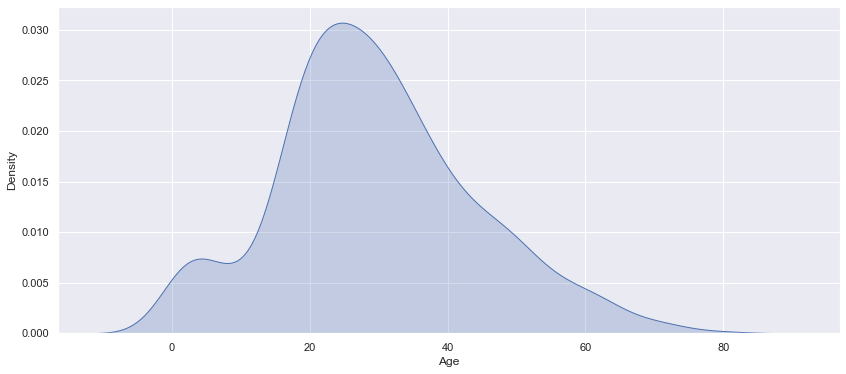

In [11]:
plt.figure(figsize=(14,6))
sns.set_theme()
sns.kdeplot(data=titanic_data['Age'], shade=True)

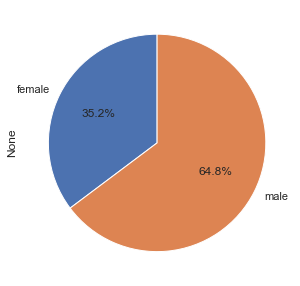

In [12]:
titanic_data.groupby('Sex').size().plot.pie(y='Sex',figsize=(5, 5),autopct='%1.1f%%', startangle=90)
plt.show()

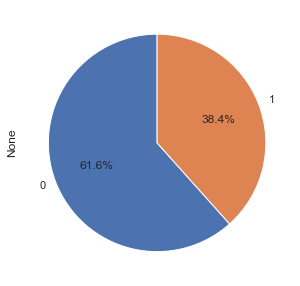

In [13]:
titanic_data.groupby('Survived').size().plot.pie(y='Survived',figsize=(5, 5),autopct='%1.1f%%', startangle=90)
plt.show()

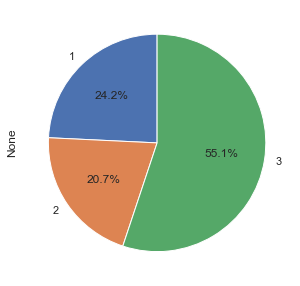

In [14]:
titanic_data.groupby('Pclass').size().plot.pie(y='Pclass',figsize=(5, 5),autopct='%1.1f%%', startangle=90)
plt.show()

<AxesSubplot:xlabel='SibSp'>

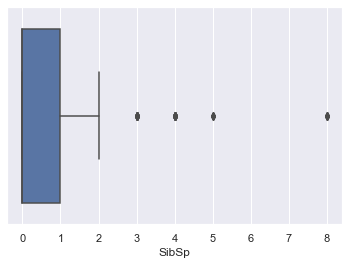

In [15]:
sns.boxplot(x=titanic_data['SibSp'])

<AxesSubplot:xlabel='Parch', ylabel='Density'>

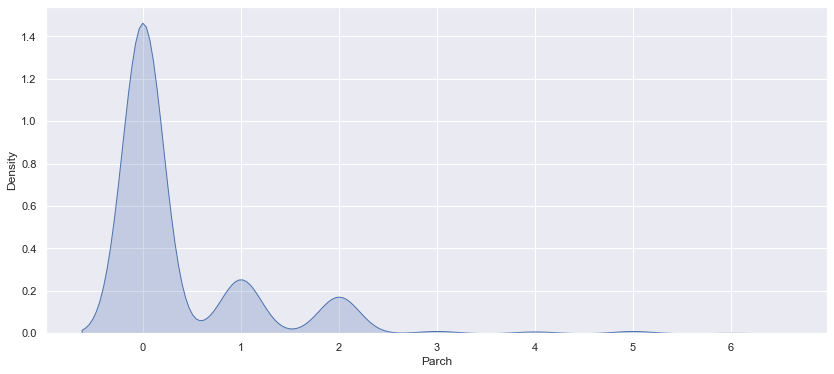

In [16]:
plt.figure(figsize=(14,6))
sns.kdeplot(data=titanic_data['Parch'], shade=True)

<AxesSubplot:xlabel='Family_Size', ylabel='Density'>

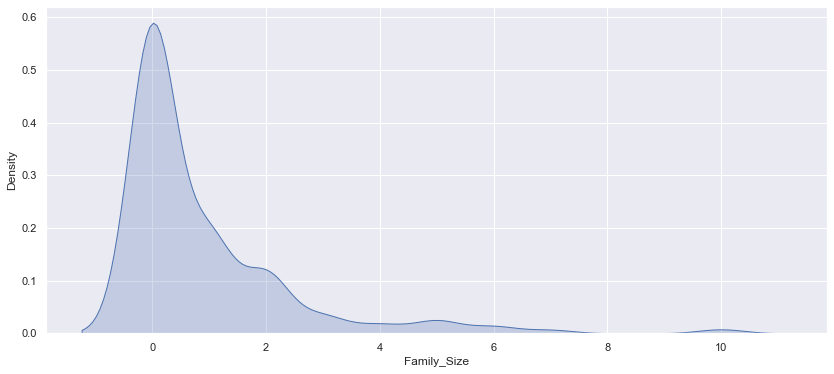

In [17]:
plt.figure(figsize=(14,6))
sns.kdeplot(data=titanic_data['Family_Size'], shade=True)

<AxesSubplot:xlabel='Fare_Per_Person'>

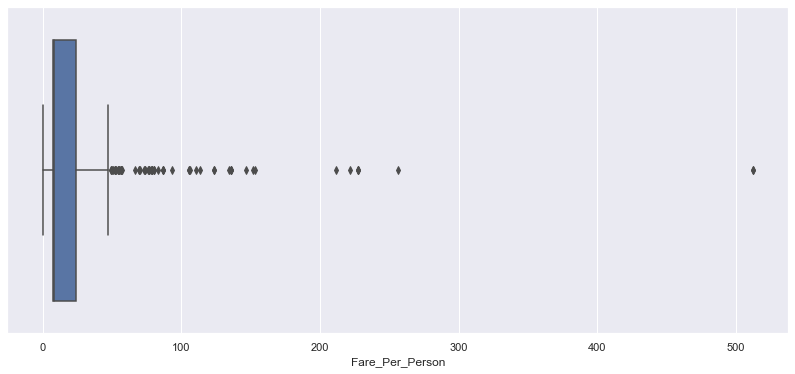

In [18]:
plt.figure(figsize=(14,6))
sns.boxplot(x=titanic_data['Fare_Per_Person'])

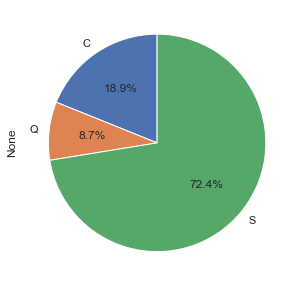

In [19]:
titanic_data.groupby('Embarked').size().plot.pie(y='Embarked',figsize=(5, 5),autopct='%1.1f%%', startangle=90)
plt.show()

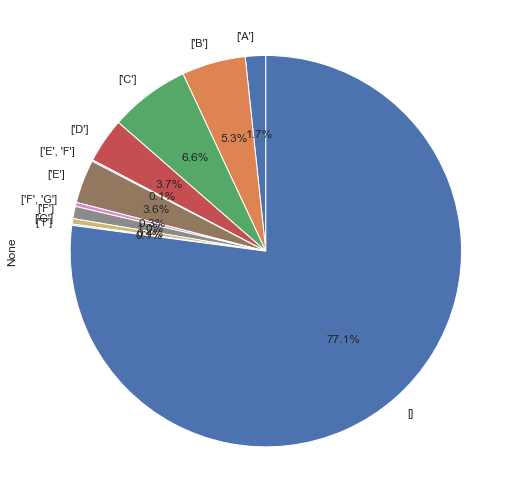

In [20]:
titanic_data.groupby('Deck').size().plot.pie(y='Deck',figsize=(9, 9),autopct='%1.1f%%', startangle=90)
plt.show()

### Exploring the relationship between each variable

<AxesSubplot:>

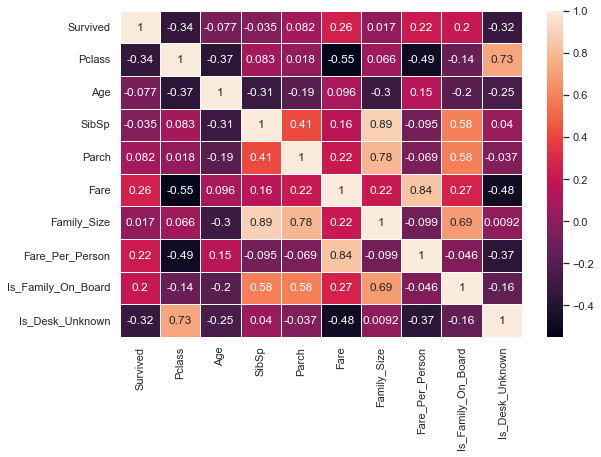

In [21]:
corrMatrix = titanic_data.corr('pearson')

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data=corrMatrix, annot=True, linewidths=.5, ax=ax)

Здесь просто зависимость разных признаков, без показа выживаемости 
Пpосто посмотреть, кто был на коробле и тд

<AxesSubplot:xlabel='Sex', ylabel='Age'>

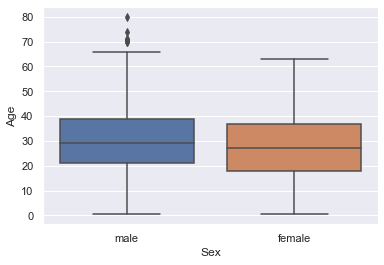

In [109]:
sns.boxplot(x='Sex', y='Age', data=titanic_data)

Нужно написать вывод о среднем возрасте мужчин и женщин на борту коробля

<AxesSubplot:xlabel='Pclass', ylabel='Age'>

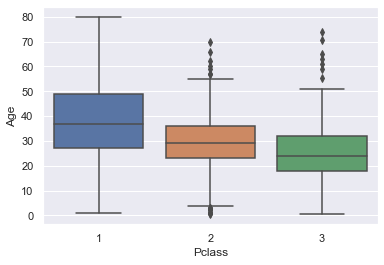

In [116]:
sns.boxplot(x='Pclass', y="Age", data=titanic_data)

<AxesSubplot:xlabel='None-Sex', ylabel='Pclass'>

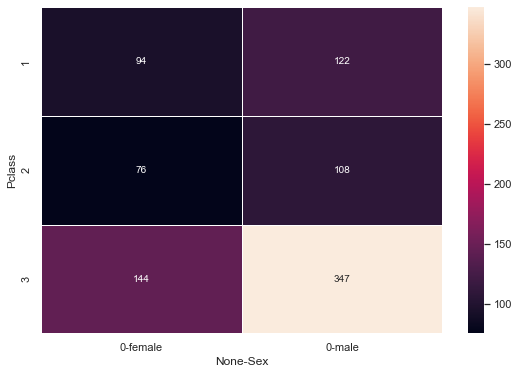

In [122]:
titanic_data_pclass = titanic_data.groupby(['Pclass', "Sex"]).size().reset_index().pivot('Pclass','Sex')
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data=titanic_data_pclass, annot=True,fmt="d", linewidths=.5, ax=ax)

<AxesSubplot:xlabel='Pclass', ylabel='Fare_Per_Person'>

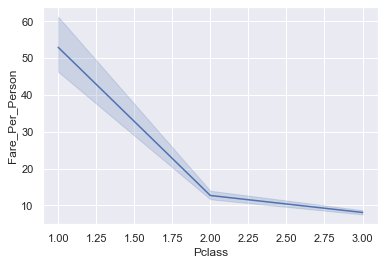

In [123]:
sns.lineplot(x= 'Pclass', y='Fare_Per_Person', data=titanic_data) 

<AxesSubplot:xlabel='Age', ylabel='Title'>

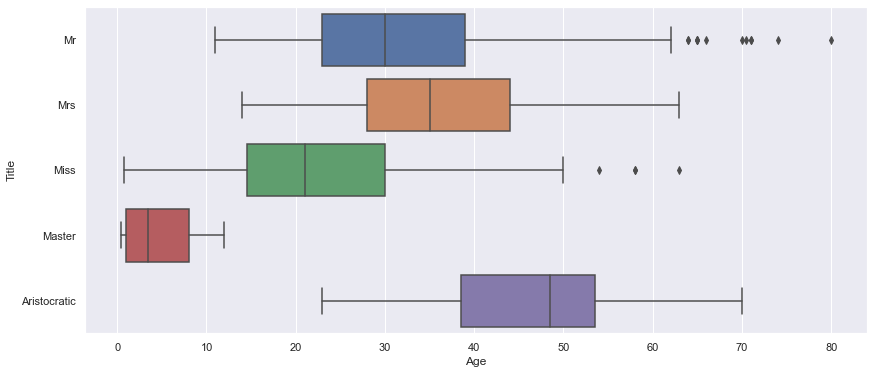

In [111]:
plt.figure(figsize=(14,6))
sns.boxplot(x='Age', y="Title", data=titanic_data)

<AxesSubplot:xlabel='Pclass', ylabel='Age'>

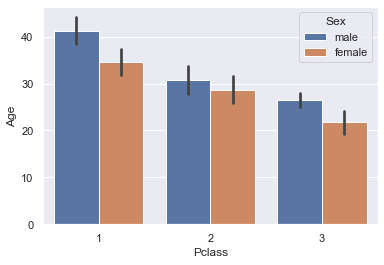

In [131]:
sns.barplot(x = 'Pclass', y ='Age', hue='Sex', data = titanic_data)

<AxesSubplot:xlabel='Family_Size', ylabel='Age'>

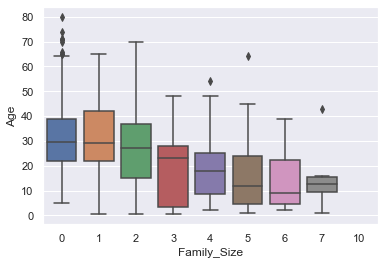

In [113]:
sns.boxplot(x='Family_Size', y='Age', data=titanic_data)

<AxesSubplot:xlabel='Is_Desk_Unknown', ylabel='Age'>

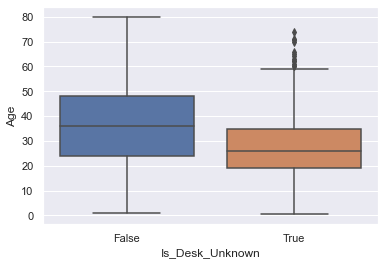

In [124]:
sns.boxplot(x='Is_Desk_Unknown', y='Age', data=titanic_data) 
#Need to check this

<AxesSubplot:xlabel='Title', ylabel='Pclass'>

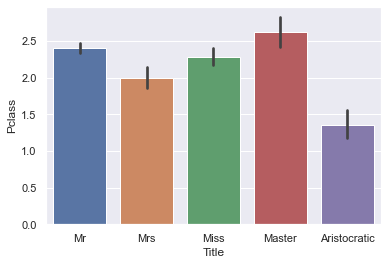

In [128]:
sns.barplot(x='Title', y='Pclass', data=titanic_data) 
#Need to check this

Здесь рассмотрим то, что напрямую связано с выживанием

<AxesSubplot:xlabel='Is_Desk_Unknown', ylabel='Survived'>

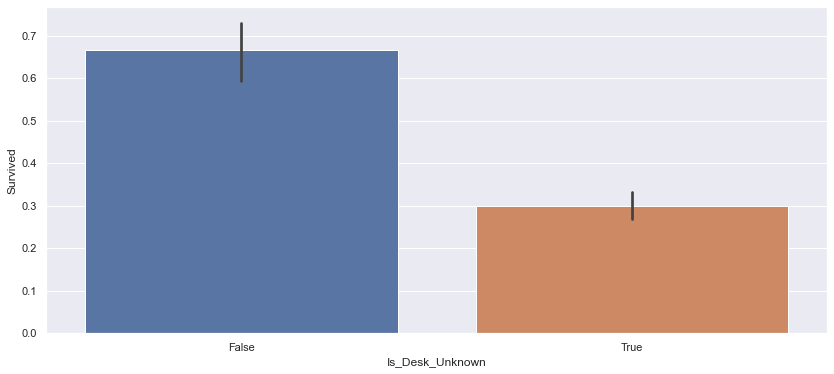

In [25]:
plt.figure(figsize=(14,6))
sns.barplot(x = 'Is_Desk_Unknown', y ='Survived', data = titanic_data)

<AxesSubplot:xlabel='Is_Desk_Unknown', ylabel='Survived'>

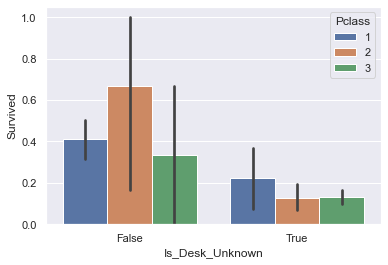

In [107]:
sns.barplot(x = 'Is_Desk_Unknown', y ='Survived', hue='Pclass', data = titanic_data_male)

<AxesSubplot:xlabel='Is_Desk_Unknown', ylabel='Survived'>

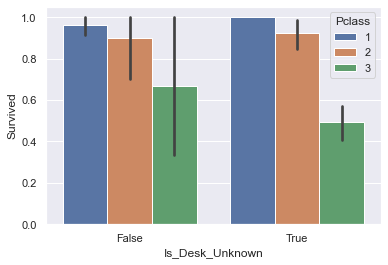

In [108]:
sns.barplot(x = 'Is_Desk_Unknown', y ='Survived', hue='Pclass', data = titanic_data_female)

<AxesSubplot:xlabel='Deck', ylabel='Survived'>

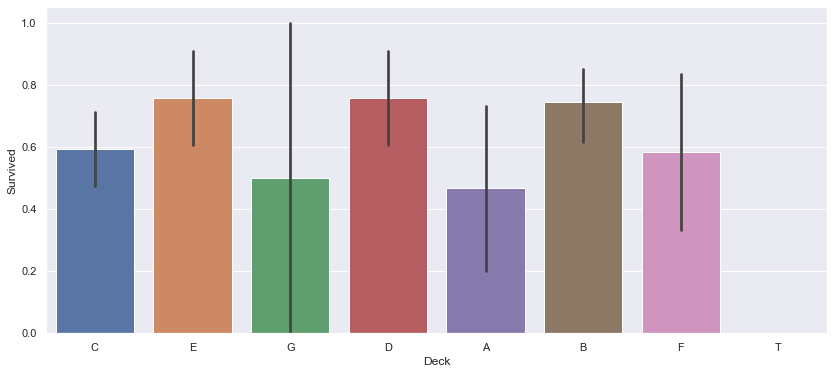

In [84]:
plt.figure(figsize=(14,6))
sns.barplot(x = 'Deck', y ='Survived', data = titanic_data[titanic_data['Deck'] != 'Unknown'])

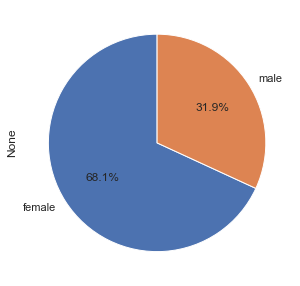

In [29]:
survived = titanic_data[titanic_data['Survived'] == 1].groupby('Sex').size()
survived.plot.pie(y='Sex',figsize=(5, 5),autopct='%1.1f%%', startangle=90)
plt.show()

<AxesSubplot:xlabel='None-Sex', ylabel='Pclass'>

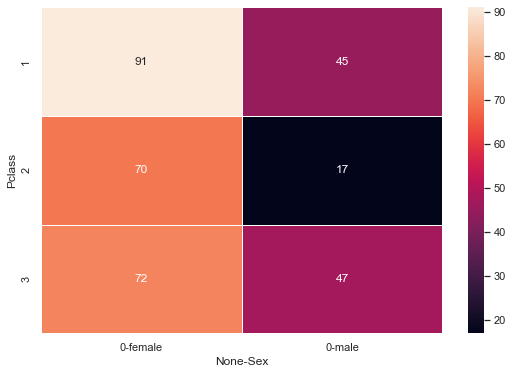

In [30]:
titanic_data_pclass_survived = titanic_data[titanic_data['Survived'] == 1] \
.groupby(['Pclass', "Sex"]).size().reset_index().pivot('Pclass','Sex')
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data=titanic_data_pclass_survived, annot=True,fmt="d", linewidths=.5, ax=ax)

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

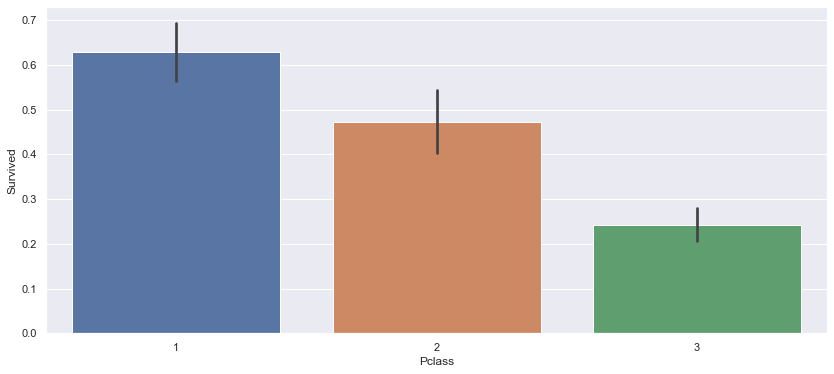

In [31]:
plt.figure(figsize=(14,6))
sns.barplot(x = 'Pclass', y ='Survived', data = titanic_data)

<AxesSubplot:xlabel='Survived', ylabel='Fare_Per_Person'>

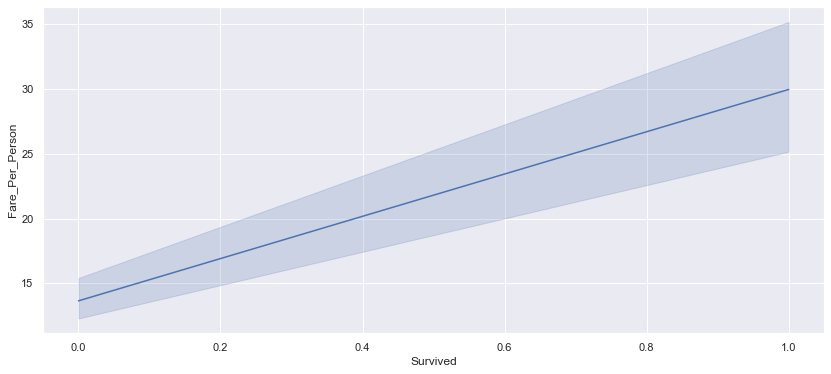

In [32]:
plt.figure(figsize=(14,6))
sns.lineplot(x= 'Survived', y='Fare_Per_Person', data=titanic_data) 

<AxesSubplot:xlabel='Age', ylabel='Density'>

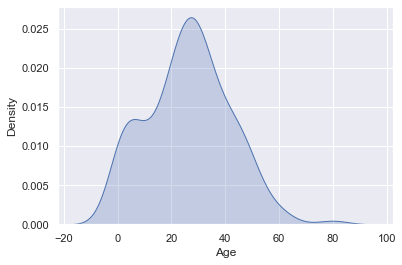

In [33]:
survived_data = titanic_data[(titanic_data['Survived']) == 1 & (titanic_data['Sex'] == 'male')]
sns.kdeplot(data=survived_data['Age'], shade=True)

<AxesSubplot:xlabel='Survived', ylabel='Age'>

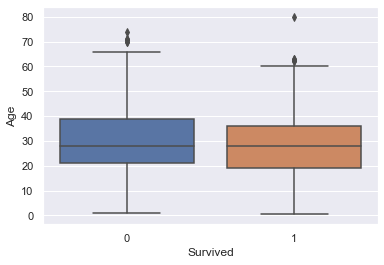

In [121]:
# sns.boxplot(x='Survived', y='Age', data=titanic_data_male)
# sns.boxplot(x='Survived', y='Age', data=titanic_data_female)
sns.boxplot(x='Survived', y='Age', data=titanic_data)

<AxesSubplot:xlabel='Title', ylabel='Survived'>

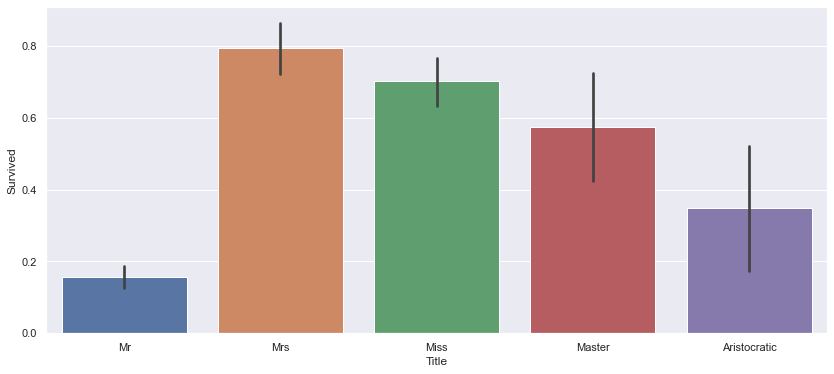

In [100]:
plt.figure(figsize=(14,6))
sns.barplot(x = 'Title', y ='Survived', data = titanic_data)

<AxesSubplot:xlabel='Age', ylabel='Survived'>

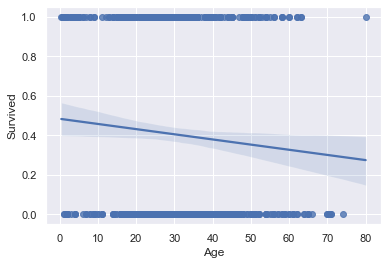

In [37]:
#sns.lineplot(x= 'Survived', y='Age', data=titanic_data)
sns.regplot(x=titanic_data['Age'], y=titanic_data['Survived'])

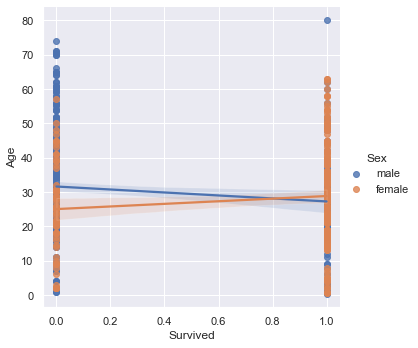

In [38]:
sns.lmplot(x="Survived", y="Age", hue="Sex", data=titanic_data)

<AxesSubplot:xlabel='Embarked', ylabel='Survived'>

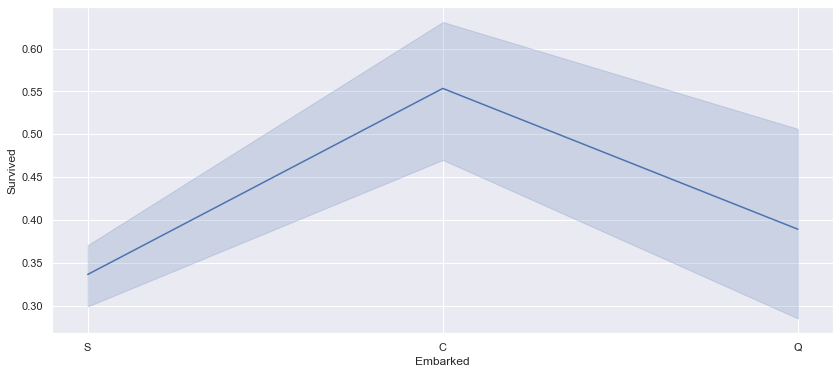

In [39]:
#Ports
#C = Cherbourg, Q = Queenstown, S = Southampton
plt.figure(figsize=(14,6))
sns.lineplot(x='Embarked', y='Survived', data=titanic_data) 

<Figure size 1008x432 with 0 Axes>

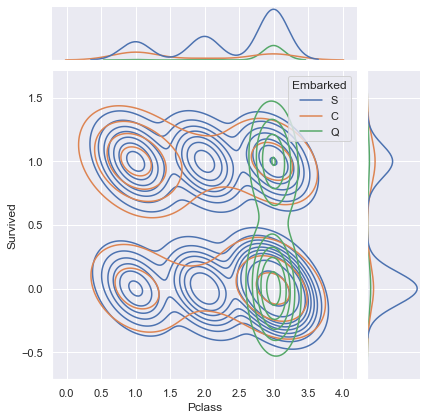

In [40]:
plt.figure(figsize=(14,6))

#sns.lineplot(x= 'Embarked', y='Pclass', data=titanic_data) 

sns.jointplot(
    data=titanic_data,
    x="Pclass", y="Survived", hue="Embarked",
    kind="kde",
)

<AxesSubplot:xlabel='Family_Size', ylabel='Survived'>

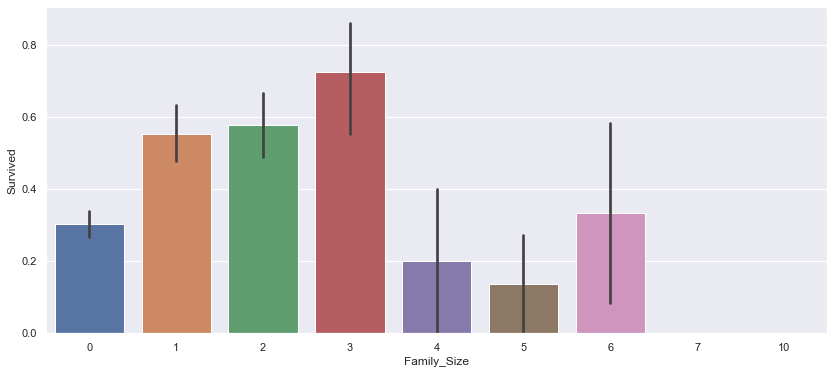

In [41]:
#Family ?
plt.figure(figsize=(14,6))

#sns.regplot(x=titanic_data['Family_Size'], y=titanic_data['Survived'])
sns.barplot(x = 'Family_Size', y ='Survived', data = titanic_data)

C:\Users\Lizka\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


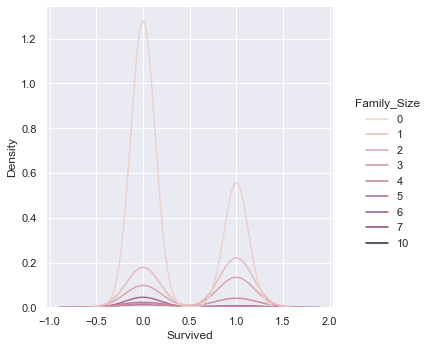

In [42]:
#sns.swarmplot(x="Family_Size", y="Survived", data=titanic_data)
sns.displot(data=titanic_data, x="Survived", hue="Family_Size", kind="kde")

<AxesSubplot:xlabel='Family_Size', ylabel='Survived'>

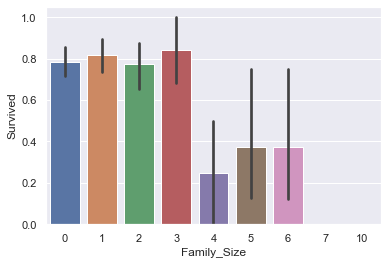

In [43]:
sns.barplot(x = 'Family_Size', y ='Survived', data = titanic_data_female)

<AxesSubplot:xlabel='Family_Size', ylabel='Survived'>

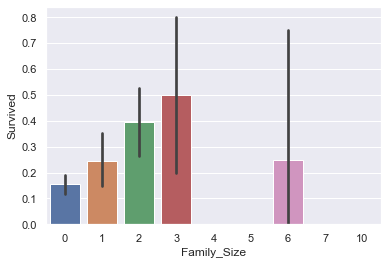

In [44]:
sns.barplot(x = 'Family_Size', y ='Survived', data = titanic_data_male)

<AxesSubplot:xlabel='Is_Family_On_Board', ylabel='Survived'>

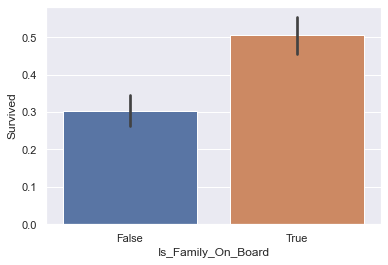

In [45]:
sns.barplot(x = 'Is_Family_On_Board', y ='Survived', data = titanic_data)

<AxesSubplot:xlabel='Is_Family_On_Board', ylabel='Survived'>

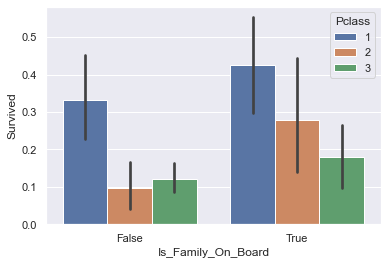

In [104]:
sns.barplot(x = 'Is_Family_On_Board', y ='Survived', hue='Pclass', data = titanic_data_male)

<AxesSubplot:xlabel='Is_Family_On_Board', ylabel='Survived'>

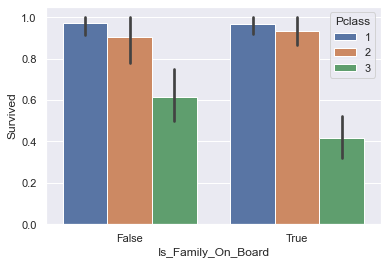

In [105]:
sns.barplot(x = 'Is_Family_On_Board', y ='Survived', hue='Pclass', data = titanic_data_female)

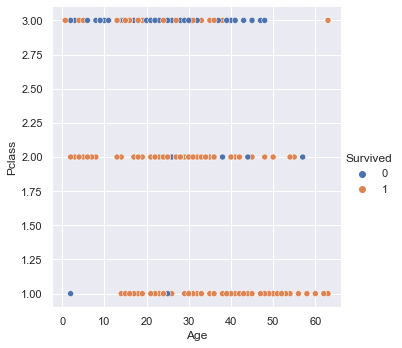

In [46]:
sns.relplot(x="Age", y="Pclass", hue="Survived", data=titanic_data_female)

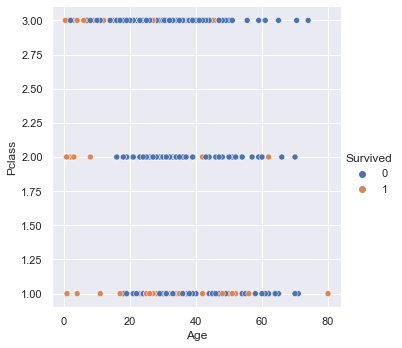

In [47]:
sns.relplot(x="Age", y="Pclass", hue="Survived", data=titanic_data_male)

<AxesSubplot:xlabel='count_7', ylabel='Survived'>

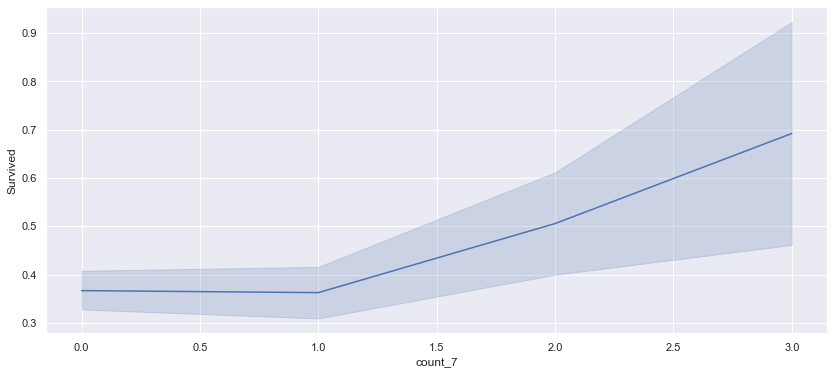

In [48]:
#Magic number 7
lucky_tickets = titanic_data;
lucky_tickets['count_7'] = pd.Index(lucky_tickets['Ticket']).str.count('7')
plt.figure(figsize=(14,6))
sns.lineplot(x= 'count_7', y='Survived', data=lucky_tickets) 

# Summary